# Mohs Hardness Regresson Competition

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e25/sample_submission.csv
/kaggle/input/playground-series-s3e25/train.csv
/kaggle/input/playground-series-s3e25/test.csv


In [2]:
# Install catboost
!pip install catboost --quiet

In [3]:
# Additional Imports
from scipy import stats

# CatBoost
from catboost import CatBoostRegressor

# Scikit learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score, median_absolute_error, max_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import ExtraTreesRegressor

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

In [4]:
# Data
train = pd.read_csv("/kaggle/input/playground-series-s3e25/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s3e25/test.csv")

In [5]:
# Check
train.head(3)

,id,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
0,0,100.0,0.841611,10.0,4.8,20.612526,11.08810,2.766,1.732,0.860,0.496070,0.91457,6.0
1,1,100.0,7.558488,10.0,4.8,20.298893,12.04083,2.755,1.631,0.910,0.492719,0.71760,6.5
2,2,76.0,8.885992,15.6,5.6,33.739258,12.08630,2.828,1.788,0.864,0.481478,1.50633,2.5


In [6]:
# Describe
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,10407.0,5203.000000,3004.386460,0.0,2601.500000,5203.000000,7804.500000,10406.000000
allelectrons_Total,10407.0,128.053516,224.123776,0.0,68.000000,100.000000,131.000000,15300.000000
density_Total,10407.0,14.491342,15.972877,0.0,7.558488,10.650000,16.676996,643.093804
allelectrons_Average,10407.0,17.033222,10.468734,0.0,10.000000,12.600000,22.000000,67.000000
val_e_Average,10407.0,4.546789,0.690864,0.0,4.000000,4.714286,4.800000,6.000000
atomicweight_Average,10407.0,37.507703,26.012313,0.0,20.298893,26.203827,48.719500,167.400000
ionenergy_Average,10407.0,10.938308,1.408276,0.0,10.590660,11.202760,11.670725,15.245810
el_neg_chi_Average,10407.0,2.607662,0.334906,0.0,2.530000,2.706000,2.805000,3.443000
R_vdw_element_Average,10407.0,1.731330,0.192481,0.0,1.672500,1.732727,1.800000,2.250000
R_cov_element_Average,10407.0,0.944132,0.180017,0.0,0.864000,0.915556,0.981667,1.615840


## EDA

In [7]:
# Drop the id field
train.drop(['id'], axis=1, inplace=True)

# Check
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10407 entries, 0 to 10406
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   allelectrons_Total     10407 non-null  float64
 1   density_Total          10407 non-null  float64
 2   allelectrons_Average   10407 non-null  float64
 3   val_e_Average          10407 non-null  float64
 4   atomicweight_Average   10407 non-null  float64
 5   ionenergy_Average      10407 non-null  float64
 6   el_neg_chi_Average     10407 non-null  float64
 7   R_vdw_element_Average  10407 non-null  float64
 8   R_cov_element_Average  10407 non-null  float64
 9   zaratio_Average        10407 non-null  float64
 10  density_Average        10407 non-null  float64
 11  Hardness               10407 non-null  float64
dtypes: float64(12)
memory usage: 975.8 KB


In [8]:
# Missing

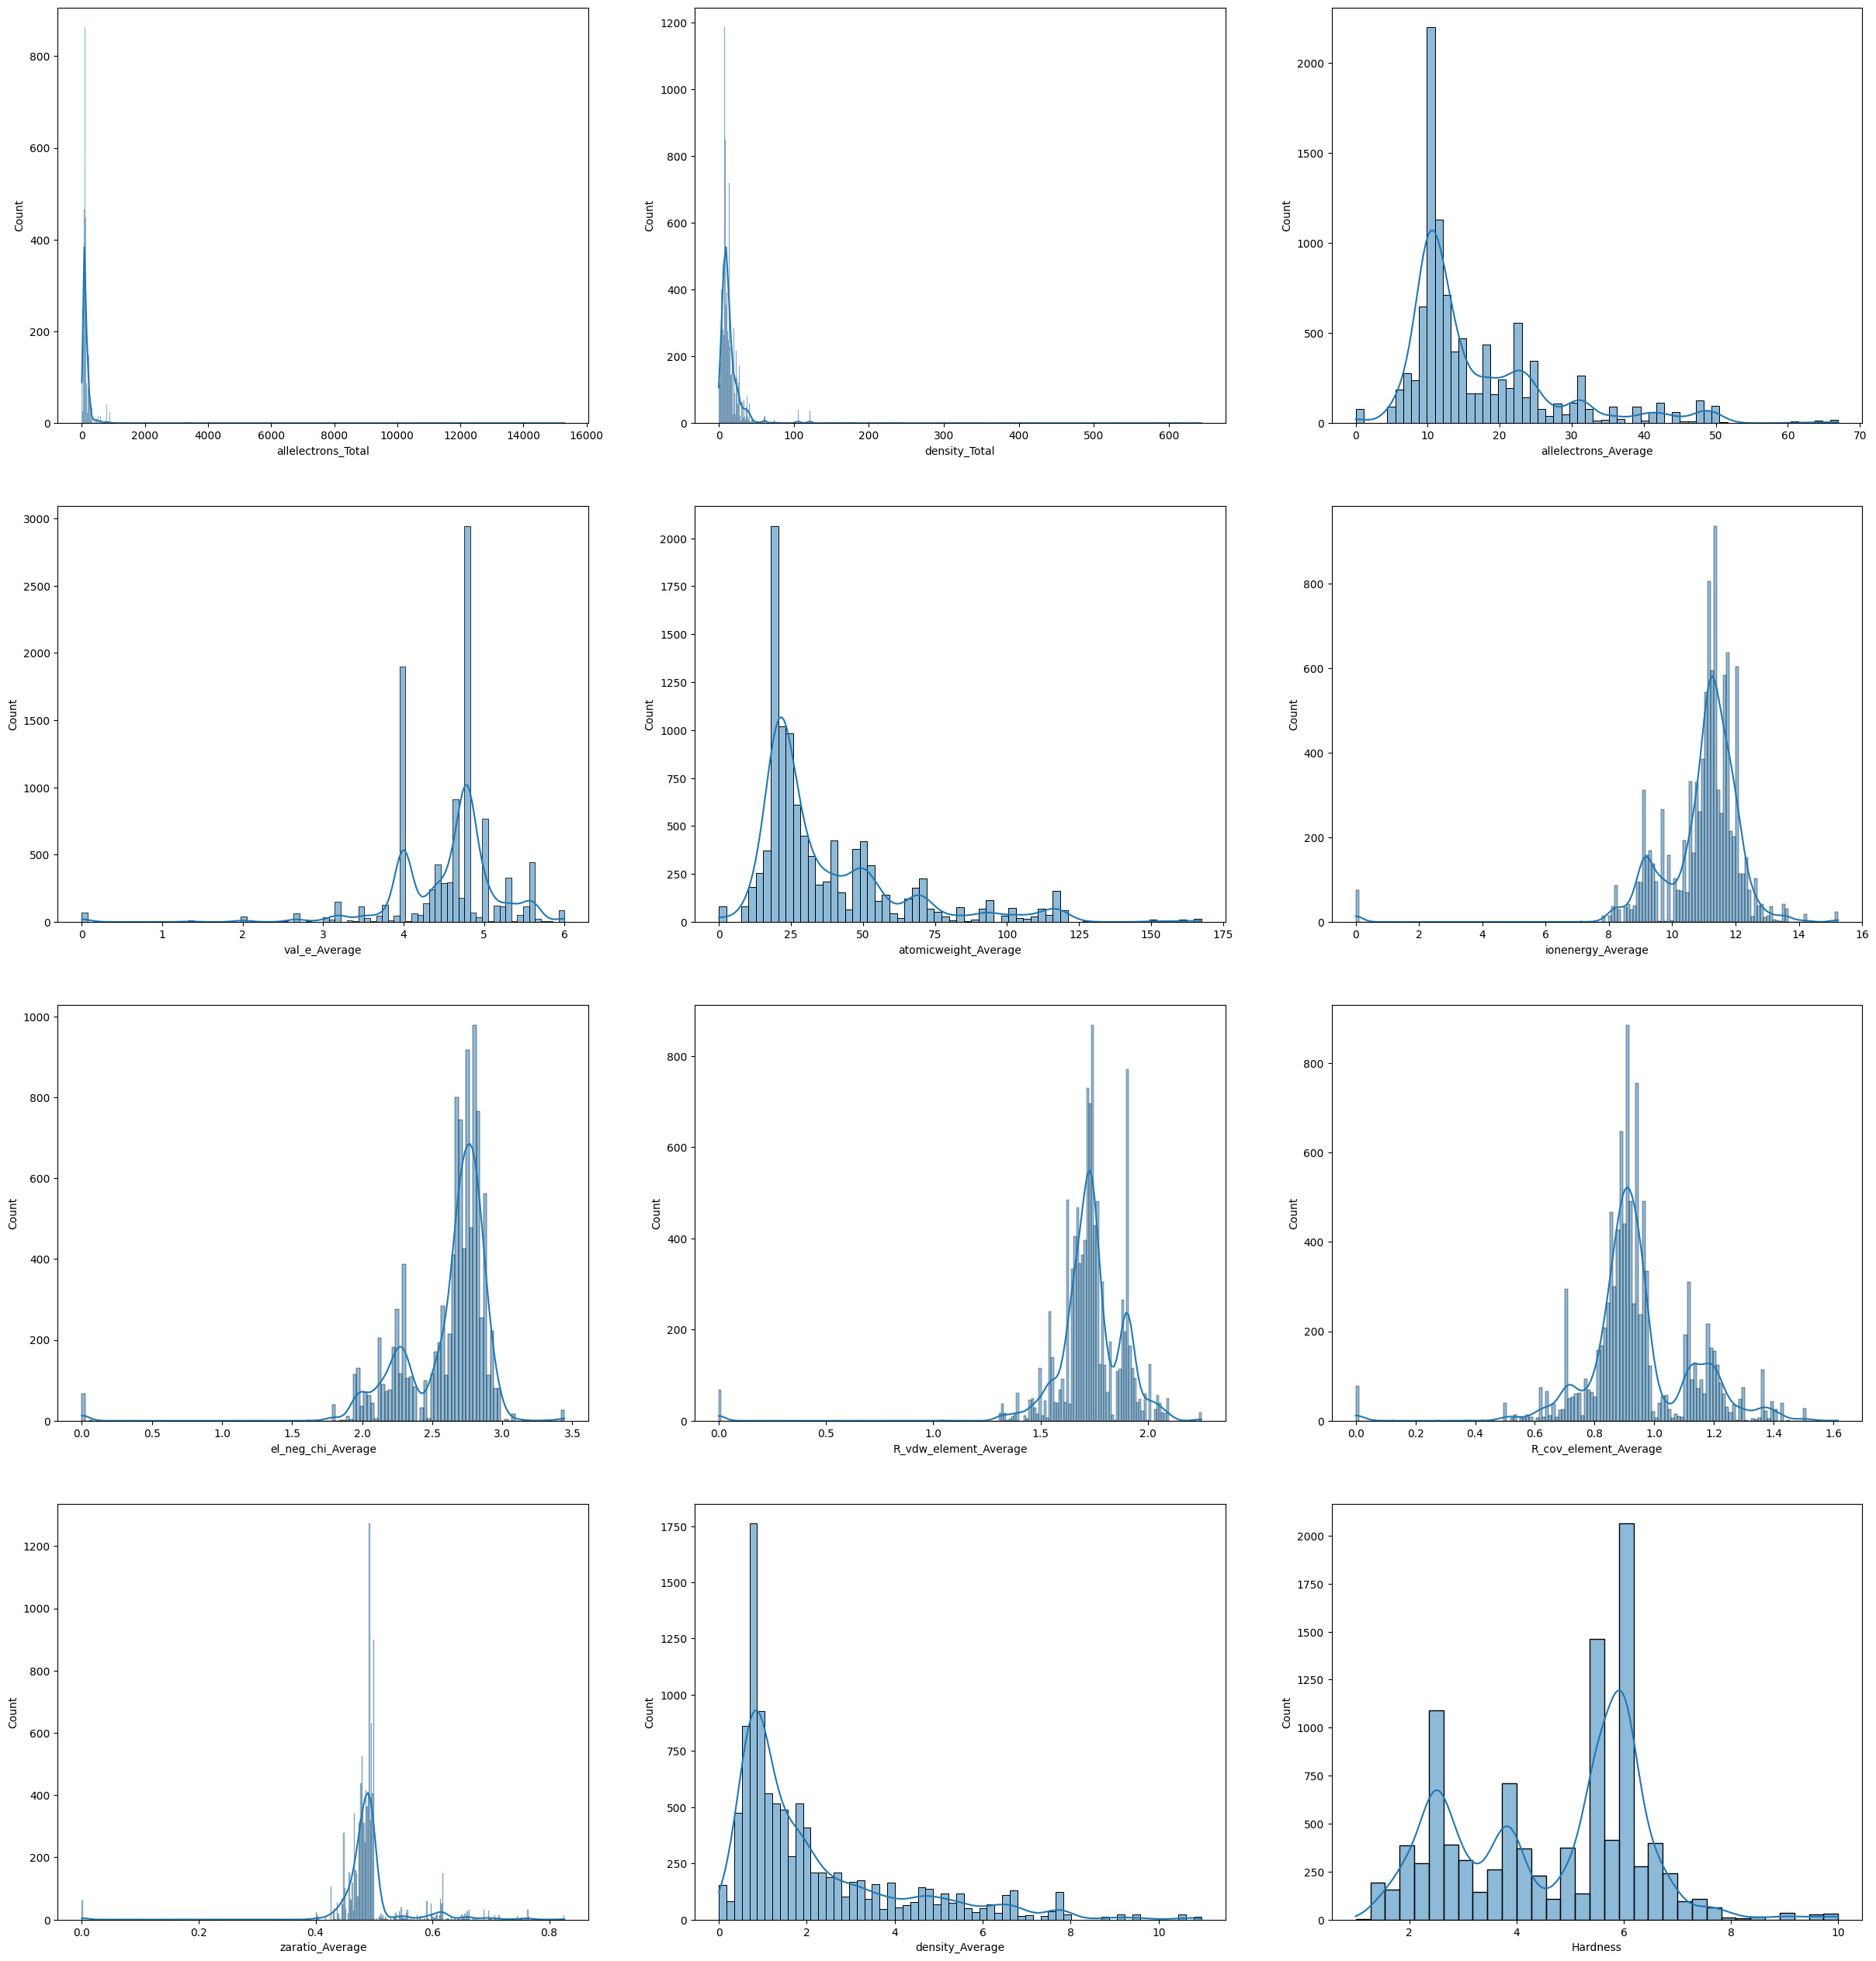

In [9]:
# Histograms
fig, axs = plt.subplots(4, 3, figsize=(30,32))

# Axes
sns.histplot(data=train, x='allelectrons_Total', kde=True, ax=axs[0, 0])

sns.histplot(data=train, x='density_Total', kde=True, ax=axs[0,1])

sns.histplot(data=train, x='allelectrons_Average', kde=True, ax=axs[0, 2])

sns.histplot(data=train, x='val_e_Average', kde=True, ax=axs[1,0])

sns.histplot(data=train, x='atomicweight_Average', kde=True, ax=axs[1, 1])

sns.histplot(data=train, x='ionenergy_Average', kde=True, ax=axs[1, 2])

sns.histplot(data=train, x='el_neg_chi_Average', kde=True, ax=axs[2, 0])

sns.histplot(data=train, x='R_vdw_element_Average', kde=True, ax=axs[2,1])

sns.histplot(data=train, x='R_cov_element_Average', kde=True, ax=axs[2,2])

sns.histplot(data=train, x='zaratio_Average', kde=True, ax=axs[3,0])

sns.histplot(data=train, x='density_Average', kde=True, ax=axs[3,1])

sns.histplot(data=train, x='Hardness', kde=True, ax=axs[3,2])

# Show
plt.show()

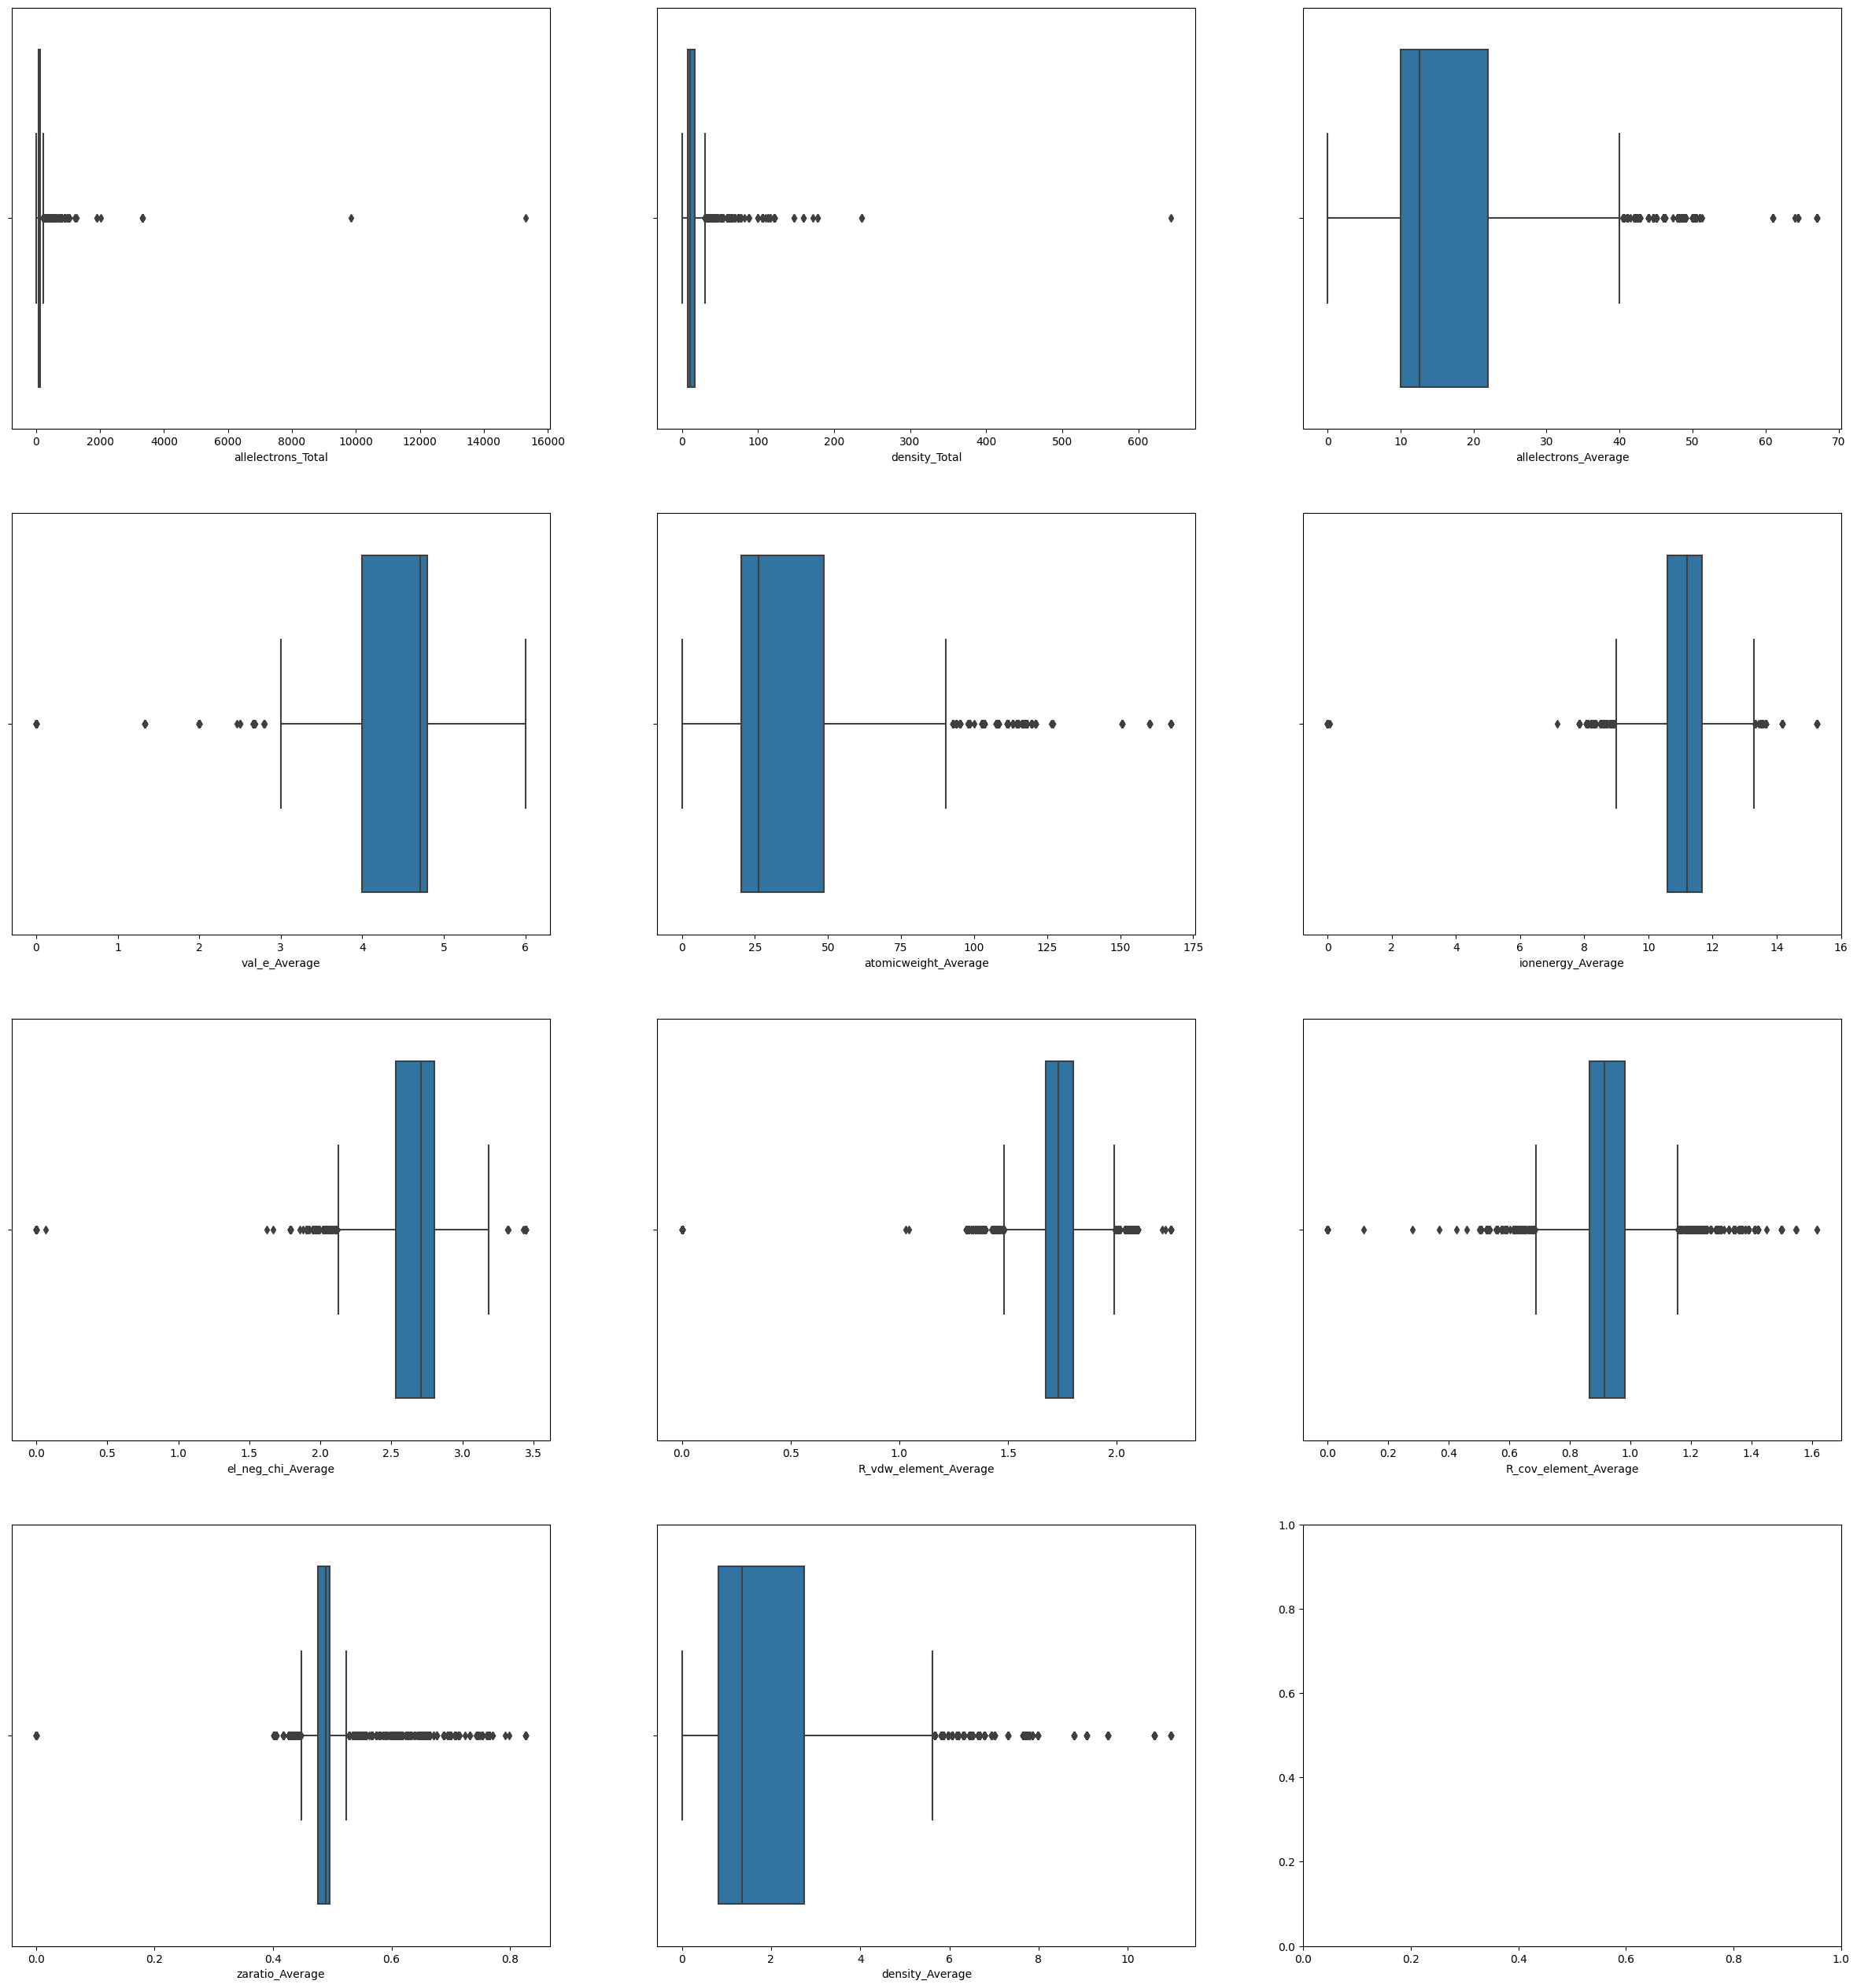

In [10]:
# Boxplots
fig, axs = plt.subplots(4, 3, figsize=(30,32))

# Axes
sns.boxplot(data=train, x='allelectrons_Total', ax=axs[0, 0])

sns.boxplot(data=train, x='density_Total', ax=axs[0,1])

sns.boxplot(data=train, x='allelectrons_Average', ax=axs[0, 2])

sns.boxplot(data=train, x='val_e_Average', ax=axs[1,0])

sns.boxplot(data=train, x='atomicweight_Average', ax=axs[1, 1])

sns.boxplot(data=train, x='ionenergy_Average', ax=axs[1, 2])

sns.boxplot(data=train, x='el_neg_chi_Average', ax=axs[2, 0])

sns.boxplot(data=train, x='R_vdw_element_Average', ax=axs[2,1])

sns.boxplot(data=train, x='R_cov_element_Average', ax=axs[2,2])

sns.boxplot(data=train, x='zaratio_Average', ax=axs[3,0])

sns.boxplot(data=train, x='density_Average', ax=axs[3,1])

# Show
plt.show()

In [11]:
# Train test split
x_train, x_val, y_train, y_val = train_test_split(train.iloc[:,:11], train.iloc[:,11], test_size=0.2, shuffle=True)

# Check sizing
print(f'Train size: {x_train.shape[0]} | Validation size: {x_val.shape[0]}')

Train size: 8325 | Validation size: 2082


In [12]:
# Normalize 
norm = MinMaxScaler()

In [13]:
# Fit
x_train = norm.fit_transform(x_train)

In [14]:
# Transform x_val
x_val = norm.transform(x_val)

## Individual Model Performance

# KNN Regressor

In [15]:
# KNN for baseline
knn = KNeighborsRegressor(metric='manhattan')

# Model fit
knn.fit(x_train, y_train)

# Predictions
knn_preds = knn.predict(x_val)

In [16]:
# Score
knn_score = knn.score(x_val, y_val)

# Other scores
knn_med = median_absolute_error(y_val, knn_preds)
knn_max_error = max_error(y_val, knn_preds)

# Show
print(f'KNN Score: {knn_score} | KNN Median Absolute Error: {knn_med} | KNN Max Error: {knn_max_error}')

KNN Score: 0.37892238812395707 | KNN Median Absolute Error: 0.6800000000000006 | KNN Max Error: 5.26


### Linear Regression

In [17]:
# Linear regression for baseline
